# Demo for InfoGANJL Training Module

Christian Landeros<br>
Harvard-MIT Program in Health Sciences and Technology

In [1]:
include("InfoGAN.jl");

┌ Info: Recompiling stale cache file /home/landeros/.julia/compiled/v1.0/InfoGAN_Fns.ji for InfoGAN_Fns [top-level]
└ @ Base loading.jl:1187


## Setup InfoGAN Module

This package can be run as a terminal script using `julia InfoGAN.jl [args]`, or it can be loaded into a jupyter notebook / REPL environment. If loading into a notebook, a dictionary with necessary hyperparemeters can be created by using `InfoGAN.define_params("args")`.
Below we see the arguments that can be included to manipulate the training architecture's hyperparameters:

In [2]:
InfoGAN.define_params("--help")

usage: InfoGAN.jl [--epochs EPOCHS] [--batchsize BATCHSIZE]
                  [--lr LR LR LR LR] [--clip CLIP] [--dreps DREPS]
                  [--greps GREPS] [--mdl MDL] [--load] [--z Z]
                  [--c_SS C_SS [C_SS...]] [--c_disc [C_DISC...]]
                  [--c_cont C_CONT] [--discCoeffSS DISCCOEFFSS]
                  [--discCoeff DISCCOEFF] [--N N] [--atype ATYPE]
                  [--printNum PRINTNUM] [-v]

Implementation of InfoGAN model described in
[https://arxiv.org/abs/1606.03657] with semi-supervised
training capacity for auxiliary networks, and updated Discriminator
loss function according to [https://arxiv.org/abs/1701.07875]

Training Hyperparameters:
  --epochs EPOCHS       Number of times to iterate through dataset
                        (type: Int64, default: 100)
  --batchsize BATCHSIZE
                        Size of data minibatches (type: Int64,
                        default: 64)
  --lr LR LR LR LR      Learning rates for AdamGrad optimizers (Fron

## Demo with MNIST Dataset:

#### Set up necessary parameters:

In [3]:
args = "--epochs 200 --lr 1e-4 1e-4 1e-4 1e-4 --clip 0.01 --z 62 --c_SS 10 --c_cont 2 --dreps 5 -v --datadir MNIST"
o = InfoGAN.define_params(args);
display(o)

Dict{Symbol,Any} with 18 entries:
  :atype       => KnetArray{Float32,N} where N
  :c_disc      => Int64[]
  :greps       => 1
  :mdl         => "trained/model.jld2"
  :printNum    => 100
  :clip        => 0.01
  :c_cont      => 2
  :batchsize   => 64
  :N           => nothing
  :v           => true
  :discCoeff   => 1.0
  :c_SS        => [10]
  :z           => 62
  :load        => false
  :dreps       => 5
  :discCoeffSS => 1.0
  :epochs      => 200
  :lr          => [0.0001, 0.0001, 0.0001, 0.0001]

#### Set up Relevant Directories:

In [4]:
LOGFILE = string(pwd(), "/tests/mnist-log.txt");
MDLFILE = string(pwd(), "/tests/mnist-model.jld2");
PRINTFOLDER = string(pwd(), "/tests/outputs");

#### Load Our Example Dataset:

In [5]:
(xtrn,xtst,ytrn,ytst) = InfoGAN.loaddata(o; keep_p = 0.2)
@info "Size of Datasets: " size(xtrn) size(xtst) size(ytrn) size(ytst)

┌ Info: Size of Datasets: 
│   size(xtrn) = (28, 28, 1, 60000)
│   size(xtst) = (28, 28, 1, 10000)
│   size(ytrn) = (1, 60000)
│   size(ytst) = (1, 10000)
└ @ Main In[5]:2


#### Visualizing MNIST Dataset:

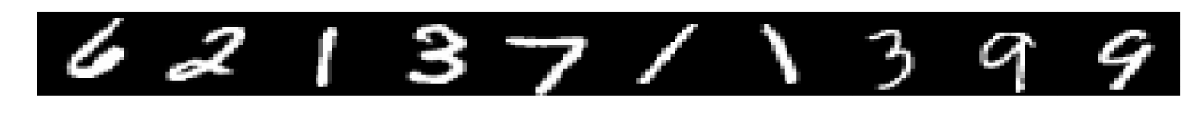

In [6]:
using Plots
xtrn .-= minimum(xtrn; dims =(1,2))
xtrn ./= maximum(xtrn; dims=(1,2))

num2show = 10
idx = rand(1:size(xtrn,4), num2show)
imgs = [xtrn[:,:,1,i]' for i = idx]; imgarr = hcat(imgs...)
plot(Gray.(imgarr), size = (num2show*120, 120), axis=false)

## Set Up Model Functions & Weights:

Model architectures can be manually defined by providing 
- initialized weights
- forward function
- array type for weights
- optimization techniques for each weight

Below we show the documentation for the default implemented Generator stored as InfoGAN.defaultG

In [7]:
? InfoGAN.defaultG

```
defaultG(wG, Z; mode=true)
```

Default Generator Network to create image samples from latent code.

<b> Arguments </b>

  * `wG::Array`: Array of neural network weights stored as KnetArray or Array.
  * `Z::Array`: latent code.
  * `mode::bool`:  batch normalization train/test mode.


Below we define our own architectures using Knet functions and we define our InfoModel using these functions and weights.

In [8]:
using Knet
bn(h, mode) = batchnorm(h, bnmoments(); training=mode)
bn_relu(h, mode) = relu.(bn(h, mode))
prelu(x, p) = max.(p .* x, x)
bn_prelu(h, mode, p) = prelu(bn(h, mode), p)

# Leaky ReLU parameter
α = 0.1;

Front End Network

In [28]:
wFE = [randn(4,4,1,64) * sqrt(2/(1*4*4)), zeros(1,1,64,1),
        randn(4,4,64,128) * sqrt(2/(64*4*4)), zeros(1,1,128,1),
        randn(1024, 5*5*128) * sqrt(2/5*5*128), zeros(1024,1)]
wFE = map(wi->convert(o[:atype], wi), wFE)

function fe_fun(w, x; mode=true)
    a = prelu(conv4(w[1], x; stride=2) .+ w[2], α)
    b = bn_prelu(conv4(w[3], a; stride=2) .+ w[4], mode, α)
    c = bn_prelu((w[5] * mat(b)) .+ w[6], mode, α)
    return c
end

fe_fun (generic function with 1 method)

Discriminator Network

In [29]:
wD = [randn(1, 1024) * sqrt(2/1024), zeros(1,1)]
wD = map(wi->convert(o[:atype], wi), wD)
function d_fun(w, fc)
    return (w[1] * fc) .+ w[2]
end

d_fun (generic function with 1 method)

Auxiliary Network


In [30]:
wQ = [randn(128, 1024) * sqrt(2/1024), zeros(128,1),
        randn(10, 128) * sqrt(2/128), zeros(10,1),
        randn(o[:c_cont]*2, 128) * sqrt(2/128), zeros(o[:c_cont]*2, 1)]
wQ = map(wi->convert(o[:atype], wi), wQ)
function q_fun(w, fc, o; mode=true)
    fc2 = bn_relu((w[1] * fc) .+ w[2], mode)
    logitsSS = [(w[3] * fc2) .+ wQ[4]]
    logits=nothing

    fc_cont = (w[5] * fc2) .+ w[6]
    mu = fc_cont[1:o[:c_cont],:]
    var = exp.(fc_cont[o[:c_cont]+1:end,:])
    return logitsSS, logits, mu, var
end

q_fun (generic function with 1 method)

Generator Network

In [31]:
wG = [randn(1024, 74) * sqrt(2/74), zeros(1024,1),
        randn(7*7*128, 1024) * sqrt(2/1024), zeros(7*7*128,1),
        randn(4,4,64,128) * sqrt(2/(128*4*4)), zeros(1,1,64,1),
        randn(3,3,64,64) * sqrt(2/(64*9)), zeros(1,1,64,1),
        randn(4,4,1,64) * sqrt(2/(64*4*4)), zeros(1,1,1,1),
        randn(3,3,1,1) * sqrt(2/(1*9)), zeros(1,1,1,1)]
wG = map(wi->convert(o[:atype], wi), wG)
function g_fun(w, Z; mode=true)
    Z= mat(Z)
    # #Linear Layers
    fc1 = bn((w[1] * Z) .+ w[2], mode)
    fc2 = bn_relu((w[3] * fc1) .+ w[4], mode)
    
    a = reshape(fc2, 7, 7, 128, :)
    
    b = deconv4(w[5], a; stride=2, padding=1) .+ w[6]
    b = bn_relu(conv4(w[7], b; padding=1) .+ w[8], mode)
    
    c = deconv4(w[9], b; stride=2, padding=1) .+ w[10]
    c = conv4(w[11], c; padding=1) .+ w[12]
    return c
end

g_fun (generic function with 1 method)

##### Neural Network Model Constructors
We then define each neural network individually as is own structure. The first way we can construct our nn structure is by supplying all four parameters.  Below we see the parameters we need.

In [32]:
dump(InfoGAN.FrontEnd)

InfoGAN_Fns.FrontEnd <: Any
  w::AbstractArray
  atype::Any
  forward::Any
  opt::AbstractArray


In [33]:
Fopt = map(x->Rmsprop(;lr=o[:lr][1]), wFE)
F = InfoGAN.FrontEnd(wFE, o[:atype], fe_fun, Fopt);

┌ Info: Initialized FrontEnd weights:
│   size(w) = (6,)
│   typeof(w) = Array{KnetArray{Float32,N} where N,1}
│   s = Number of Parameters: 3.410 M

└ @ InfoGAN_Fns /home/landeros/julia-notebooks/InfoGANJL/InfoGAN_Fns.jl:21


The defualt RMSprop optimizer will be used if only the weights, function, and parameter dictionary are supplied:

In [34]:
G = InfoGAN.Generator(wG, o, g_fun)
D = InfoGAN.Discriminator(wD, o, d_fun)
Q = InfoGAN.Auxiliary(wQ, o, q_fun)

model = InfoGAN.InfoModel(F, D, G, Q, o);

┌ Info: Initialized Generator weights:
│   size(w) = (12,)
│   typeof(w) = Array{KnetArray{Float32,N} where N,1}
│   s = Number of Parameters: 6.675 M

└ @ InfoGAN_Fns /home/landeros/julia-notebooks/InfoGANJL/InfoGAN_Fns.jl:63
┌ Info: Initialized Discriminator weights:
│   size(w) = (2,)
│   typeof(w) = Array{KnetArray{Float32,2},1}
│   s = Number of Parameters: 0.001 M

└ @ InfoGAN_Fns /home/landeros/julia-notebooks/InfoGANJL/InfoGAN_Fns.jl:42
┌ Info: Initialized Auxiliary weights:
│   size(w) = (6,)
│   typeof(w) = Array{KnetArray{Float32,2},1}
│   s = Number of Parameters: 0.133 M

└ @ InfoGAN_Fns /home/landeros/julia-notebooks/InfoGANJL/InfoGAN_Fns.jl:86


## Train our model using the specified data set and specified parameters

Finally, we can use our constructed InfoModel and loaded dataset to initiate training

In [ ]:
@time results = InfoGAN.train(xtrn, ytrn, xtst, ytst, model; mdlfile=MDLFILE, logfile=LOGFILE, printfolder=PRINTFOLDER);

	Batch Discriminator Loss: 6.272e-02 (D: 6.272e-02, GP: 0.000e+00)
	Batch1 L-Gen: -3.684e+00, L-DiscSS: 2.949, L-Disc: 0.000, and L-Cont: 0.702

	Batch Discriminator Loss: -1.130e-01 (D: -1.130e-01, GP: 0.000e+00)
	Batch1 L-Gen: -3.770e+00, L-DiscSS: 2.415, L-Disc: 0.000, and L-Cont: 0.231

	Batch Discriminator Loss: -3.476e-01 (D: -3.476e-01, GP: 0.000e+00)
	Batch1 L-Gen: -3.645e+00, L-DiscSS: 2.725, L-Disc: 0.000, and L-Cont: 0.192

	Batch Discriminator Loss: 1.130e-01 (D: 1.130e-01, GP: 0.000e+00)
	Batch1 L-Gen: -3.727e+00, L-DiscSS: 2.358, L-Disc: 0.000, and L-Cont: 0.169

	Batch Discriminator Loss: 1.044e-01 (D: 1.044e-01, GP: 0.000e+00)
	Batch1 L-Gen: -3.748e+00, L-DiscSS: 2.755, L-Disc: 0.000, and L-Cont: 0.170

	Batch Discriminator Loss: 7.247e-02 (D: 7.247e-02, GP: 0.000e+00)
	Batch1 L-Gen: -4.016e+00, L-DiscSS: 2.527, L-Disc: 0.000, and L-Cont: 0.117

	Batch Discriminator Loss: 3.843e-01 (D: 3.843e-01, GP: 0.000e+00)
	Batch1 L-Gen: -3.857e+00, L-DiscSS: 2.534, L-Disc: 0.000, 

In [ ]:
plot(results, xlabel = "Epoch Number", ylabel="Loss", label=["Discriminator", "Generator"])

In [ ]:
function get_results(epoch_init, epoch_final, interval, img_dir)
    epochs = epoch_init:interval:epoch_final
    p, imgs = [], []
    for e = epochs
        imgfile = string(img_dir, "/epoch", lpad(e, 3, "0"), ".png")
        img = convert(Array{Float32}, channelview(Gray.(load(imgfile))))[1:56, 1:56]
        push!(imgs, img)
    end
    return imgs, epochs
end

In [ ]:
using Images
IMGDIR = string(pwd(), "/tests/outputs");
imgs, epochs = get_results(10,100,10, IMGDIR);
imgsarr = hcat(imgs...);
size(imgsarr)

h = 120
plot(Gray.(imgsarr), size = (length(epochs)*h, h), axis=false)

## Viewing Categorizations

In [ ]:
preds = InfoGAN.get_c(xtst, model);

In [ ]:
using MLBase
confusmat(10, convert(Array{Int64}, ytst[1,:]), preds[1,:])

### Generated Samples